# Comparison study between hard decision Hamming and using a Chase-2 wrapper

1. Baseline - Raw SNR <--> BER using PAM-4 and Gray coding.
2. Encode and decode with Clause 177-1 68,60 matrix as a single error correcting Hamming code.
3. Using a PAM4 classifier (probabilities), find 2 LPRs., and decode using a Chase-2 wrapper



In [41]:
#First introduce the project directory so all python modules could be loaded
import os, sys
projectDir = os.environ.get('IEEE8032DJ')
#You don't have to define an environment variable, but then you have to give a path to the project here
if projectDir == None: 
     projectDir = "c:/users/omer/802.3/"
sys.path.insert(1, projectDir)
reedSolomonProjectDir = os.environ.get('REEDSOLOMON')
if reedSolomonProjectDir == None: 
     reedSolomonProjectDir = "c:/users/omer/reedSolomon/reedSolomon/"
sys.path.insert(1, reedSolomonProjectDir)
import numpy as np
import matplotlib.pyplot as plt
import modulationFunctions as mf
from ieee8023dj_d0p1 import encode_177_5
from hammingBasics import simpleHammingDecoder, hammingWrapper128_68_128, indexToSyndrome, syndromeToIndex, bitsXOR128_68
from ieeeConstants import parityMatrix_177_5, g_177_1, IEEE_8023_INT_DATA_TYPE
from comparisonStudy import simpleAWGNComparison
from chase2 import chase2Decoder

def encoder(x):
    return encode_177_5(G = g_177_1, x)


0.1484375
[0.1484375]
[0 0 0 1 0 1 1 1 0 1 0 0 1 1 0 1 1 0 1 0 1 1 1 1 1 0 1 0 1 0 1 0 0 0 0 1 0
 0 0 1 0 1 0 1 0 1 0 1 1 1 1 1 0 0 1 0 1 0 0 0 0 1 1 0 0 1 1 0 1 0 0 1 1 1
 0 1 0 0 0 0 1 0 0 1 0 0 1 0 0 0 1 0 1 1 1 1 0 0 0 1 0 1 1 1 0 0 1 0 0 0 1
 1 1 0 1 1 0 1 0 0 0 0 1 1 1 1 0 1]
And the fix:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0.4921875]


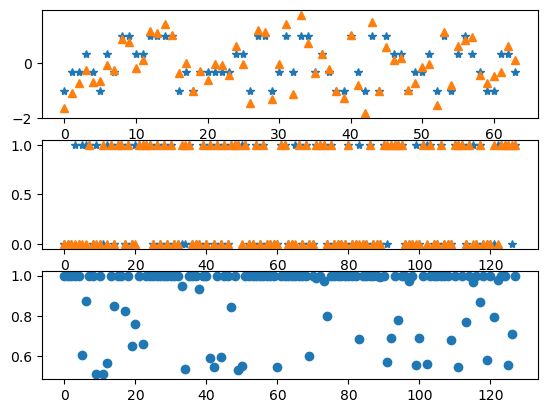

In [48]:
# Create a local prng for reproducibility 
localPrng = np.random.RandomState(8023)
# create an instance of clause 177 Hamming encoder with bit pair XOR
SNR_MIN     = 0
SNR_MAX     = 0 #16
MESSAGE_LENGTH = 120
CODEWORD_LENGTH = 128
numberOfCodewords = 10
AVERAGE_POWER_PER_BIT_PAM4 = 1 #Currently 1, as half of epsilon_g which is 2
CORRECTION_FACTOR = 0.5 # This factor is meant to be removed once I figure out the right conversion from linear SNR to noise
PAM4_SER_TO_BER = 3/4 # This needs checking and explaining.
EbN0_dB    = np.arange(SNR_MIN,SNR_MAX+1,1)
EbN0_linear        = 10**(EbN0_dB/10.0)  # linear SNR
berStatsPam4GrayCoded = np.zeros(len(EbN0_linear))
berStatsPam4Chase2 = np.zeros(len(EbN0_linear))
berStatsPam4Hamming = np.zeros(len(EbN0_linear))
LOCAL_PRNG = np.random.RandomState(8023)
COSEWORD_SIZE = 128
DATA_SIZE = 120

loop = 0
numberOfCodewords = 1
for snr in EbN0_linear:  
    fig, ax = plt.subplots(3)
    
    
    numberOfBits = COSEWORD_SIZE * numberOfCodewords #Omer:  need to change this to be a function of SNR
    # signal vector, new vector for each SNR value
    # Randomize some binary data (for testing Hamming alone it's enough to use the all 0 codeword, but not enough for testing LPR + Chase-2)
    data = localPrng.randint(0,2, (numberOfCodewords, DATA_SIZE), dtype = IEEE_8023_INT_DATA_TYPE)
    
    #Now encode the data using Hamming 177-5
    encodedData = list(map(encoder, [data[:,k] for k in range(numberOfCodewords)]))
    
    
    ax[1].plot(data, '*')
    #modulatedDataNoGrayCoding, pam4SymbolsNoGrayCoding, _ = mf.modulatePAM4(data, grayCoding=False, precoding=False)
    modulatedDataGrayCoded, pam4SymbolsGrayCoded, _ = mf.modulatePAM4(data, grayCoding=True, precoding=False)
    ax[0].plot(modulatedDataGrayCoded,'*')
    
    # noise
    noisePam4 = LOCAL_PRNG.normal(0, CORRECTION_FACTOR * np.sqrt(0.5 * (AVERAGE_POWER_PER_BIT_PAM4 / snr)), len(modulatedDataGrayCoded))
    
    # signal + noise
    noisyDataGrayCoded = modulatedDataGrayCoded + noisePam4
    ax[0].plot(noisyDataGrayCoded, '^') 

    # slice received signal + noise
    #pam4SymbolsNoGrayCoding, error, classifier = mf.pam4Slice(noisyDataNoGrayCoding)
    pam4SymbolsGrayCoded, error, classifier = mf.pam4Slice(noisyDataGrayCoded)
    receivedBits, receivedProbabilities = mf.pam4ClassifierToBits(classifier)
    ax[1].plot(receivedBits, '^')
    ax[2].plot(receivedProbabilities, 'o')
    
    #dataRxNoGrayCoding = mf.pam4SymbolsToBits(pam4SymbolsNoGrayCoding, grayCoded= False)
    dataRxGrayCoded = mf.pam4SymbolsToBits(pam4SymbolsGrayCoded, grayCoded= True)
    
    #Reshape received data to COSEWORD_SIZE X numberOfCodewords
    receivedMessages = np.reshape(dataRxGrayCoded, [COSEWORD_SIZE, numberOfCodewords], order = 'C')
    # Use Hamming on sliced data
    decodedDataHamming = list(map(hammingWrapper128_68_128, [receivedMessages[:,k] for k in range(receivedMessages.shape[1])]))
    # And use Chase-2 with the classifier (soft data)
    #decodedDataChase2, score, decoderFailure, results = chase2Decoder(hammingWrapper128_68_128, receivedBits, receivedProbabilities, numberOfLeastProbable = 2)

    # find erroneous bits
    print(np.sum(dataRxGrayCoded != data) / numberOfBits)
    berStatsPam4GrayCoded[loop] += np.sum(dataRxGrayCoded != data) / numberOfBits
    print(berStatsPam4GrayCoded)
    dataReshaped = np.reshape(data, [COSEWORD_SIZE, numberOfCodewords], order = 'C')
    
    print(dataReshaped[:,0])
    print("And the fixed data:")
    print(decodedDataHamming[0][0])
    for l in range(len(decodedDataHamming)): # I'm assuming here that the messages are ordered the same as the original data sent using map
        #print(dataReshaped[:,l].shape)
        berStatsPam4Hamming[loop] += np.sum(decodedDataHamming[l][0] != dataReshaped[:,l])
    berStatsPam4Hamming[loop] = berStatsPam4Hamming[loop] / numberOfBits
    print(berStatsPam4Hamming)
    #berStatsPam4Chase2[loop] += np.sum(decodedDataChase2 != data) / numberOfBits
    loop += 1
    
